[[1.15777930e+03 0.00000000e+00 6.67111054e+02]
 [0.00000000e+00 1.15282291e+03 3.86128937e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] [[-0.24688775 -0.02373134 -0.00109842  0.00035108 -0.00258569]]
[[1.15777930e+03 0.00000000e+00 6.67111054e+02]
 [0.00000000e+00 1.15282291e+03 3.86128937e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] [[-0.24688775 -0.02373134 -0.00109842  0.00035108 -0.00258569]]


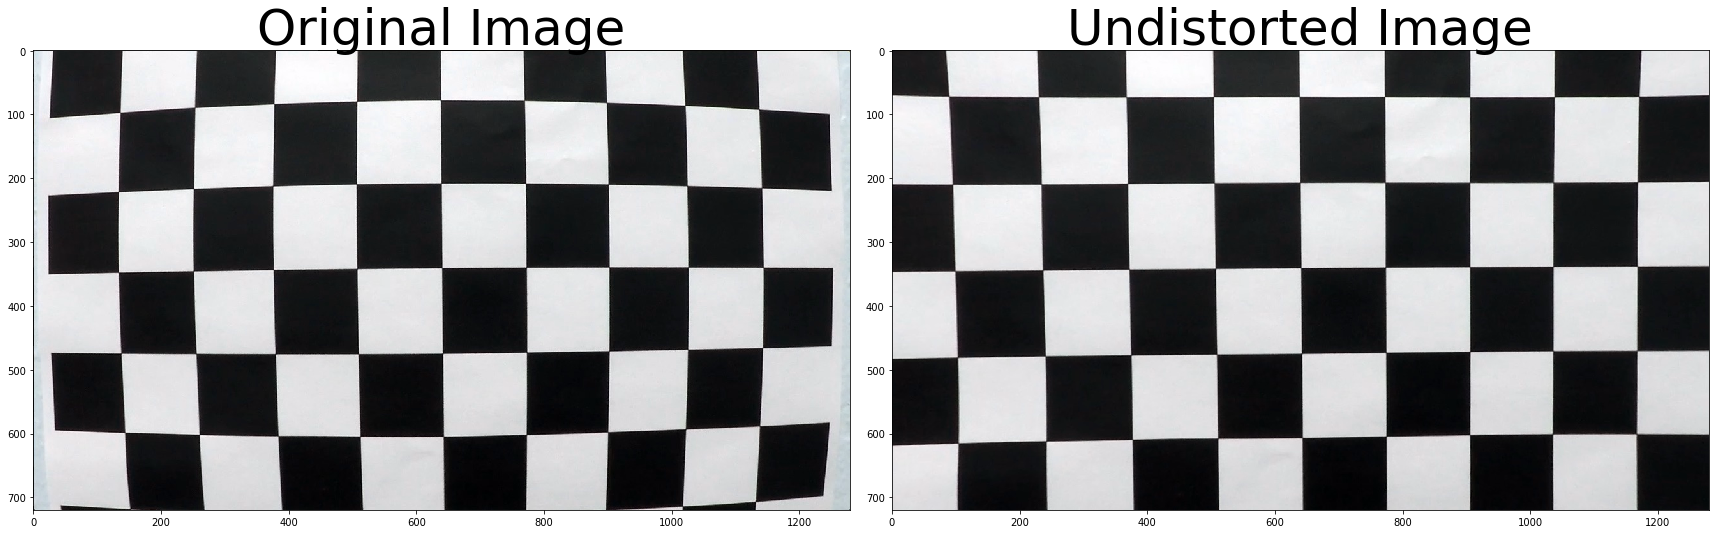

In [51]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from tracker import tracker
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

objpoints = [] # 3d points in real world
imgpoints = [] # 2d points in image

# prepare object points
objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

images = glob.glob("./camera_cal/calibration*.jpg")
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

# calibrate camera
img = cv2.imread("./camera_cal/calibration1.jpg")
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
print(mtx, dist)
undist_img = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist_img)
ax2.set_title('Undistorted Image', fontsize=50)

img = cv2.imread("./test_images/test1.jpg")
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
print(mtx, dist)


In [31]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if (orient == 'x'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sxbinary


# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def color_select(img, sthresh=(0, 255), vthresh=(0, 255)):
    # 1) Convert to HLS color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    S = hsv[:,:,1]
    V = hsv[:,:,2]
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(S)
    binary_output[(S > sthresh[0]) & (S <= sthresh[1]) & (V > vthresh[0]) & (V <= vthresh[1])] = 1
    # 3) Return a binary image of threshold result
    # binary_output = np.copy(img) # placeholder line
    return binary_output


def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output



In [62]:

# set up window
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
curve_centers = tracker(window_width, window_height, margin = 25, ym = ym_per_pix, xm = xm_per_pix, smooth_factor = 15) 

#images = glob.glob("./test_images/test*.jpg")
#for i,fname in enumerate(images):
 #   img = cv2.imread(fname)
def process_image(img):
    #print(img.shape)
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    # print(type(undist_img))
    
    # generate binary image by applying sobel filter and color space filter
    preprocess_img = np.zeros_like(undist_img[:,:,0])
    gradx = abs_sobel_thresh(undist_img, orient='x', thresh=(12,255))
    grady = abs_sobel_thresh(undist_img, orient='y', thresh=(25,255))
    s_color = color_select(undist_img, sthresh=(100,255), vthresh=(50,255))
    preprocess_img[((gradx == 1) & (grady == 1) | (s_color == 1))] = 255
    
    # transform the image to a top-down view
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[img_size[0]*.46, img_size[1]*.63 ], 
                      [img_size[0]*.54, img_size[1]*.63 ], 
                      [img_size[0]*.88, img_size[1]*.93 ], 
                      [img_size[0]*.12, img_size[1]*.93]])
    offset = img_size[0]*.25
    dst = np.float32([[offset, 0 ], 
                      [img_size[0]-offset, 0 ], 
                      [img_size[0]-offset, img_size[1] ], 
                      [offset, img_size[1]]])
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(preprocess_img, M, img_size, flags=cv2.INTER_LINEAR)
    
    # fit ploynomial to warped image
    window_width = 25
    window_height = 80
    
    # set up window
    #curve_centers = tracker(window_width, window_height, margin = 25, ym = 10/720, xm = 4/384, smooth_factor = 15)
   
    window_centroids = curve_centers.find_window_centroids(warped)
    
    # Points used to draw all the left and right windows
    #l_points = np.zeros_like(warped)
    #r_points = np.zeros_like(warped)
    
    # Points to find the left and right lances
    rightx = []
    leftx = []
    
    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])
        
        # Window_mask is a function to draw window areas
        #l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        #r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        #l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        #r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    #template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    #zero_channel = np.zeros_like(template) # create a zero color channel
    #template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    #warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
    #output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
     
    #write_name = "./output_images/color_fit"+str(i)+'.jpg'
    #cv2.imwrite(write_name, output)
    
    # fit the lance boundaries to the left, right center position
    yvals = range(0, warped.shape[0])
    
    res_yvals = np.arange(warped.shape[0] - window_height / 2, 0, -window_height)
    
    left_fit = np.polyfit(res_yvals, leftx, 2)
    left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]
    left_fitx = np.array(left_fitx, np.int32)
    
    right_fit = np.polyfit(res_yvals, rightx, 2)
    right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
    right_fitx = np.array(right_fitx, np.int32)
    
    left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2,left_fitx[::-1]+window_width/2), axis=0), np.concatenate((yvals, yvals[::-1]),axis=0))),np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2,right_fitx[::-1]+window_width/2), axis=0), np.concatenate((yvals, yvals[::-1]),axis=0))),np.int32)
    inner_lane = np.array(list(zip(np.concatenate((left_fitx+window_width/2,right_fitx[::-1]-window_width/2), axis=0), np.concatenate((yvals, yvals[::-1]),axis=0))),np.int32)

    road = np.zeros_like(img)
    road_bkg = np.zeros_like(img)
    cv2.fillPoly(road, [left_lane], color = [255,0,0])
    cv2.fillPoly(road, [right_lane], color = [0,0,255])
    cv2.fillPoly(road, [inner_lane], color = [0,255,0])
    cv2.fillPoly(road_bkg, [left_lane], color = [255,255,255])
    cv2.fillPoly(road_bkg, [right_lane], color = [255,255,255])
    
    road_warped = cv2.warpPerspective(road, M_inv, img_size, flags=cv2.INTER_LINEAR)
    road_warped_bkg = cv2.warpPerspective(road_bkg, M_inv, img_size, flags=cv2.INTER_LINEAR)
    
    result = cv2.addWeighted(img, 1.0, road_warped_bkg, -1.0, 0,0)
    result = cv2.addWeighted(result, 1.0, road_warped, 1.0, 0.0)
    
    ym_per_pix = curve_centers.ym_per_pix
    xm_per_pix = curve_centers.xm_per_pix
    
    curve_fit_cr = np.polyfit(np.array(res_yvals,np.float32)*ym_per_pix, np.array(leftx, np.float32)*xm_per_pix,2) 
    curverad = ((1 + (2*curve_fit_cr[0]*yvals[-1]*ym_per_pix + curve_fit_cr[1])**2)**1.5)/np.absolute(2*curve_fit_cr[0])
    
    # calculate the offset of the car on the road
    camera_center = (left_fitx[-1] + right_fitx[-1])/2
    center_diff = (camera_center-warped.shape[1]/2)*xm_per_pix
    side_pos = 'left' if center_diff > 0 else 'right'
        
    cv2.putText(result, 'Radius of Curvature = ' + str(round(curverad,3)) + '(m)', (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    cv2.putText(result, 'vehicle is ' + str(abs(round(center_diff,3))) + '(m) ' + side_pos + ' of the center', (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)

    
    return result
    

In [63]:
video_output = './project_video_output.mp4'
clip1 = VideoFileClip("./project_video.mp4")
video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./project_video_output.mp4
[MoviePy] Writing video ./project_video_output.mp4


100%|█████████▉| 1260/1261 [01:36<00:00, 13.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_output.mp4 

CPU times: user 2min 19s, sys: 20.1 s, total: 2min 39s
Wall time: 1min 36s


In [64]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [55]:
video_output = './challenge_video_output.mp4'
clip1 = VideoFileClip("./challenge_video.mp4")
video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./challenge_video_output.mp4
[MoviePy] Writing video ./challenge_video_output.mp4


100%|██████████| 485/485 [00:37<00:00, 13.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./challenge_video_output.mp4 

CPU times: user 53.2 s, sys: 8.4 s, total: 1min 1s
Wall time: 37.9 s


In [56]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))